In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import talib

In [2]:
df = pd.read_csv('HistoricalData_1643468836007.csv')
df

,Date,Close/Last,Volume,Open,High,Low
0,01/28/2022,$170.33,179935700,$165.71,$170.35,$162.8
1,01/27/2022,$159.22,121954600,$162.45,$163.84,$158.28
2,01/26/2022,$159.69,108275300,$163.5,$164.3894,$157.82
3,01/25/2022,$159.78,115798400,$158.98,$162.76,$157.02
4,01/24/2022,$161.62,162706700,$160.02,$162.3,$154.7
...,...,...,...,...,...,...
2513,02/03/2012,$16.4171,286475725,$16.3321,$16.4286,$16.27
2514,02/02/2012,$16.2543,186460101,$16.2821,$16.3275,$16.2136
2515,02/01/2012,$16.2925,269077484,$16.3718,$16.3925,$16.2696
2516,01/31/2012,$16.3029,391497243,$16.2711,$16.3657,$16.1811


In [3]:
#Removing the $ signs from each value, not needed & messes up my plot
df[['Close/Last', 'Open', 'High', 'Low']] = df[['Close/Last', 'Open', 'High', 'Low']].replace({r'\$':''}, regex = True)

# Making sure everything is in the right dtype, easier for the model?
df['Date'] = pd.to_datetime(df['Date'])
df['Close/Last'] = pd.to_numeric(df['Close/Last'])
df['Open'] = pd.to_numeric(df['Open'])
df['High'] = pd.to_numeric(df['High'])
df['Low'] = pd.to_numeric(df['Low'])

print(df.dtypes)
df

Date          datetime64[ns]
Close/Last           float64
Volume                 int64
Open                 float64
High                 float64
Low                  float64
dtype: object


,Date,Close/Last,Volume,Open,High,Low
0,2022-01-28,170.3300,179935700,165.7100,170.3500,162.8000
1,2022-01-27,159.2200,121954600,162.4500,163.8400,158.2800
2,2022-01-26,159.6900,108275300,163.5000,164.3894,157.8200
3,2022-01-25,159.7800,115798400,158.9800,162.7600,157.0200
4,2022-01-24,161.6200,162706700,160.0200,162.3000,154.7000
...,...,...,...,...,...,...
2513,2012-02-03,16.4171,286475725,16.3321,16.4286,16.2700
2514,2012-02-02,16.2543,186460101,16.2821,16.3275,16.2136
2515,2012-02-01,16.2925,269077484,16.3718,16.3925,16.2696
2516,2012-01-31,16.3029,391497243,16.2711,16.3657,16.1811


In [37]:
df.to_csv('cleaned_stock_prices_csv')

In [4]:
close_price_data_since_2020 = df[df['Date'] >= '31-12-2019'].copy()
cleaned_df = close_price_data_since_2020.drop(['Open', 'High', 'Low'], axis = 1)
cleaned_df= cleaned_df.sort_values(by = 'Date', ascending = True)
cleaned_df

,Date,Close/Last,Volume
524,2019-12-31,73.4125,100990520
523,2020-01-02,75.0875,135647440
522,2020-01-03,74.3575,146535520
521,2020-01-06,74.9500,118578560
520,2020-01-07,74.5975,111510640
...,...,...,...
4,2022-01-24,161.6200,162706700
3,2022-01-25,159.7800,115798400
2,2022-01-26,159.6900,108275300
1,2022-01-27,159.2200,121954600


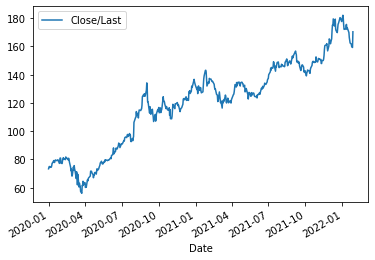

In [5]:
cleaned_df.plot(kind = 'line', x = 'Date', y = 'Close/Last')
plt.show()

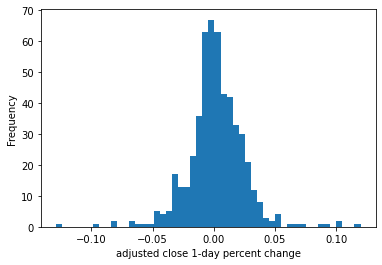

In [6]:
cleaned_df['Close/Last'].pct_change(1).plot.hist(bins = 50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.046731
5d_close_future_pct     -0.046731             1.000000


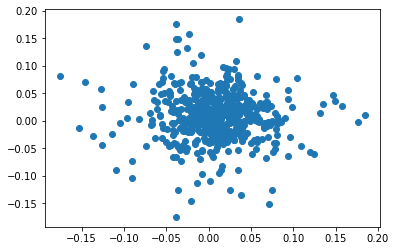

In [7]:
cleaned_df['5d_future_close'] = cleaned_df['Close/Last'].shift(-5)
cleaned_df['5d_close_future_pct'] = cleaned_df['5d_future_close'].pct_change(5)
cleaned_df['5d_close_pct'] = cleaned_df['Close/Last'].pct_change(5)

corr = cleaned_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

plt.scatter(cleaned_df['5d_close_pct'], cleaned_df['5d_close_future_pct'])
plt.show()

5-day change is slightly negatively correlated to the change in the last 5 days

## Adding a moving average(ma) [14, 30, 50 200 day]  and RSI

In [8]:
feature_names = ['5d_close_pct']

for n in [14, 30, 50, 200]:
    cleaned_df['ma' + str(n)] = talib.SMA(cleaned_df['Close/Last'].values, timeperiod=n) / cleaned_df['Close/Last']
    
    cleaned_df['rsi' + str(n)] = talib.RSI(cleaned_df['Close/Last'].values, timeperiod=n) 
    
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
    
print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [9]:
cleaned_df = cleaned_df.dropna()
features = cleaned_df['5d_close_pct'].values
targets = cleaned_df['5d_close_future_pct'].values


In [10]:
linear_features = sm.add_constant(features)

train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]

print(linear_features.shape, train_features.shape, test_features.shape)

(320, 2) (272, 2) (48, 2)


## Fitting a linear model

In [11]:
model = sm.OLS(train_targets, train_features)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.414
Date:                Sun, 06 Feb 2022   Prob (F-statistic):              0.121
Time:                        20:54:01   Log-Likelihood:                 537.38
No. Observations:                 272   AIC:                            -1071.
Df Residuals:                     270   BIC:                            -1064.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.002      2.774      0.0

In [12]:
print(results.pvalues)

[0.00592359 0.12139236]


In [13]:
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

print(train_predictions)
print()
print()
print(test_predictions)

[ 1.05603653e-03  4.08166167e-03  1.20388883e-02  8.48660604e-03
  9.04705134e-03  9.55540082e-03  8.84097887e-03  6.46707971e-03
  6.44143657e-03  1.02487902e-02  6.06518577e-03  1.07348482e-02
  1.08155794e-02  1.06517135e-02  2.56912392e-03  2.71402358e-03
 -2.71414849e-03 -7.63665015e-04  1.04236809e-03  2.03007944e-03
  5.57706154e-03  5.26981288e-03  2.52309228e-03  2.96437975e-03
  6.85928525e-03  6.16478566e-03  7.22167469e-03  1.07250911e-02
  9.01902138e-03  7.30063606e-03  7.33185576e-03  4.35740509e-03
 -1.55714026e-03 -6.95360870e-04  1.56993057e-04  1.18489374e-03
  2.03159433e-03  4.45511238e-03  6.70460957e-03  5.49040306e-03
  5.59605846e-03  7.20485764e-03  3.09052259e-03  1.09437468e-03
  1.58106041e-03  2.47989490e-03  7.72311809e-04  2.79732345e-03
  3.41676634e-03  3.34561169e-03 -1.68054125e-03  8.82728462e-04
  4.41539195e-03  4.48467619e-03  7.52975133e-03  9.59869918e-03
  1.14443585e-02  7.67364765e-03  6.16868852e-03  6.02856751e-03
  7.29354799e-03  2.55388

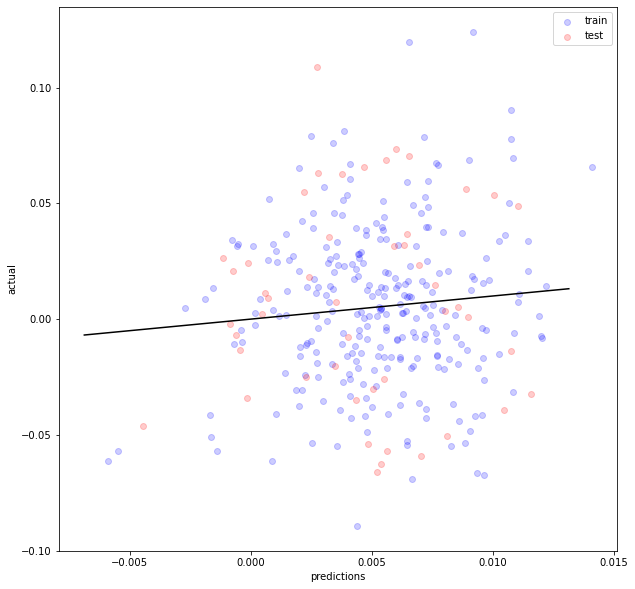

In [14]:
fig=plt.figure(figsize=(10,10))
plt.scatter(train_predictions, train_targets, alpha = 0.2, color = 'b', label = 'train')
plt.scatter(test_predictions, test_targets, alpha = 0.2, color = 'r', label = 'test')

xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

In [15]:
cleaned_df

,Date,Close/Last,Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
324,2020-10-15,120.71,112559200,115.75,-0.041090,0.049926,0.969709,56.815625,0.951574,56.231528,0.968626,56.927172,0.733934,56.267101
323,2020-10-16,119.02,115393800,115.04,-0.033440,0.017526,0.985915,54.011382,0.964565,54.918670,0.983240,56.067806,0.746201,56.014970
322,2020-10-19,115.98,120639300,115.05,-0.008019,-0.067685,1.012921,49.297839,0.988416,52.632027,1.009852,54.556115,0.767554,55.564843
321,2020-10-20,117.51,124423700,116.60,-0.007744,-0.029645,1.000766,51.587757,0.976877,53.637083,0.997517,55.176762,0.759371,55.744726
320,2020-10-21,116.87,89945980,111.20,-0.048515,-0.035647,1.006295,50.559111,0.982098,53.149090,1.004262,54.856973,0.765338,55.650016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,2022-01-14,173.07,80440780,161.62,-0.066158,0.005227,1.016641,50.342881,1.008935,55.512339,0.965612,56.759791,0.847210,56.005510
8,2022-01-18,169.80,91168730,159.78,-0.059011,-0.013880,1.032227,44.995256,1.029927,52.653169,0.986426,54.872652,0.864818,55.491563
7,2022-01-19,166.23,94814990,159.69,-0.039343,-0.050548,1.048745,39.999691,1.052229,49.758737,1.009410,52.912823,0.884595,54.938390
6,2022-01-20,164.51,91420520,159.22,-0.032156,-0.062781,1.053766,37.820999,1.061879,48.431791,1.021674,51.999766,0.894957,54.674480


In [16]:
cleaned_df = cleaned_df.set_index('Date')


In [17]:
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)

cleaned_df['Adj_Volume_1d_change'] = cleaned_df['Volume'].pct_change()
cleaned_df['Adj_Volume_1d_change_SMA'] = talib.SMA(cleaned_df['Adj_Volume_1d_change'].values, timeperiod = 5)
cleaned_df

,Close/Last,Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA
Date,,,,,,,,,,,,,,,
2020-10-15,120.71,112559200,115.75,-0.041090,0.049926,0.969709,56.815625,0.951574,56.231528,0.968626,56.927172,0.733934,56.267101,NaN,NaN
2020-10-16,119.02,115393800,115.04,-0.033440,0.017526,0.985915,54.011382,0.964565,54.918670,0.983240,56.067806,0.746201,56.014970,0.025183,NaN
2020-10-19,115.98,120639300,115.05,-0.008019,-0.067685,1.012921,49.297839,0.988416,52.632027,1.009852,54.556115,0.767554,55.564843,0.045457,NaN
2020-10-20,117.51,124423700,116.60,-0.007744,-0.029645,1.000766,51.587757,0.976877,53.637083,0.997517,55.176762,0.759371,55.744726,0.031370,NaN
2020-10-21,116.87,89945980,111.20,-0.048515,-0.035647,1.006295,50.559111,0.982098,53.149090,1.004262,54.856973,0.765338,55.650016,-0.277099,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-14,173.07,80440780,161.62,-0.066158,0.005227,1.016641,50.342881,1.008935,55.512339,0.965612,56.759791,0.847210,56.005510,-0.048103,0.001702
2022-01-18,169.80,91168730,159.78,-0.059011,-0.013880,1.032227,44.995256,1.029927,52.653169,0.986426,54.872652,0.864818,55.491563,0.133365,-0.017887
2022-01-19,166.23,94814990,159.69,-0.039343,-0.050548,1.048745,39.999691,1.052229,49.758737,1.009410,52.912823,0.884595,54.938390,0.039995,0.047485


In [18]:
days_of_week = pd.get_dummies(cleaned_df.index.dayofweek, prefix = 'weekday', drop_first = True)
days_of_week.index = cleaned_df.index

cleaned_df = pd.concat([cleaned_df, days_of_week], axis = 1)

feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
cleaned_df.dropna(inplace = True)
cleaned_df

,Close/Last,Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,,,
2020-10-22,115.75,101988000,115.32,-0.003715,-0.041090,1.017717,48.727975,0.992252,52.287878,1.014453,54.295047,0.774469,55.484220,0.133881,-0.008242,0,0,1,0
2020-10-23,115.04,82572650,108.86,-0.053720,-0.033440,1.023091,47.552220,0.999257,51.738099,1.020719,53.937648,0.780885,55.379102,-0.190369,-0.051352,0,0,0,1
2020-10-26,115.05,111850700,108.77,-0.054585,-0.008019,1.024176,47.571408,0.999082,51.745491,1.020655,53.942005,0.782445,55.380299,0.354573,0.010471,0,0,0,0
2020-10-27,116.60,92276770,110.44,-0.052830,-0.007744,1.011492,50.588905,0.986103,52.902245,1.007429,54.620941,0.773646,55.565924,-0.175001,-0.030803,1,0,0,0
2020-10-28,111.20,143937800,114.95,0.033723,-0.048515,1.058190,41.604903,1.033711,48.695223,1.055567,51.901142,0.812700,54.768156,0.559849,0.136587,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-14,173.07,80440780,161.62,-0.066158,0.005227,1.016641,50.342881,1.008935,55.512339,0.965612,56.759791,0.847210,56.005510,-0.048103,0.001702,0,0,0,1
2022-01-18,169.80,91168730,159.78,-0.059011,-0.013880,1.032227,44.995256,1.029927,52.653169,0.986426,54.872652,0.864818,55.491563,0.133365,-0.017887,1,0,0,0
2022-01-19,166.23,94814990,159.69,-0.039343,-0.050548,1.048745,39.999691,1.052229,49.758737,1.009410,52.912823,0.884595,54.938390,0.039995,0.047485,0,1,0,0


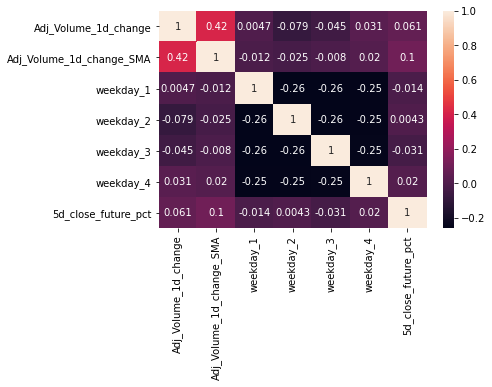

In [19]:
import seaborn as sns

new_features.extend('weekday_' + str(i) for i in range(1, 5))
sns.heatmap(cleaned_df[new_features + ['5d_close_future_pct']].corr(), annot = True)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

In [20]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor()
decision_tree.fit(train_features, train_targets)

print(decision_tree.score(train_features, train_targets))
print()
print()
print(decision_tree.score(test_features, test_targets))

1.0


-0.4999653900227625


As you can see on training data there is a good fit however on the test data, it scores poorly. To see different values you can create a for loop in order to see different max_depths to see which would yield a good score . Ideally when looking at a suitable values you would want to look at values that yield the smallest -ve value so below max_depth which would be suitable would be 3

In [21]:
for d in [3, 5, 10, 30]:
    decision_tree = DecisionTreeRegressor(max_depth = d)
    decision_tree.fit(train_features, train_targets)
    
    print('max_depth =', str(d))
    print()
    print(decision_tree.score(train_features, train_targets))
    print()
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth = 3

0.12461903322460399

-0.20462141254561272 

max_depth = 5

0.24217774837179162

-0.2107903762577319 

max_depth = 10

0.4548055246720967

-0.28088798177178775 

max_depth = 30

1.0

-0.4999653900227625 



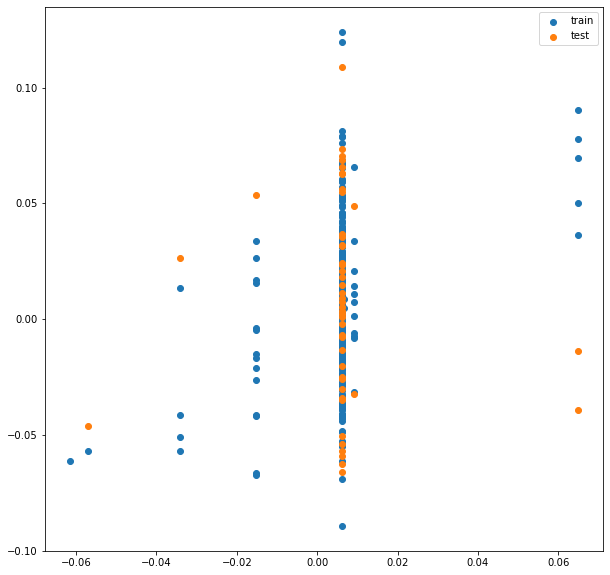

In [22]:
decision_tree = DecisionTreeRegressor(max_depth = 3)
decision_tree.fit(train_features, train_targets)

train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

fig=plt.figure(figsize=(10,10))
plt.scatter(train_predictions, train_targets, label = 'train')
plt.scatter(test_predictions, test_targets, label = 'test')
plt.legend()
plt.show()

**The predictions group into lines since our depth is so limited and therefore if we have a higher max_depth then it would look like so:**

In [23]:
#decision_tree = DecisionTreeRegressor(max_depth = 30)
#decision_tree.fit(train_features, train_targets)

#train_predictions = decision_tree.predict(train_features)
#test_predictions = decision_tree.predict(test_features)

#fig=plt.figure(figsize=(10,10))
#plt.scatter(train_predictions, train_targets, label = 'train')
#plt.scatter(test_predictions, test_targets, label = 'test')
#plt.legend()
#plt.show()

In [24]:
'''FITTING A RANDOM FOREST'''

from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 200)
rfr.fit(train_features, train_targets)

print(rfr.score(train_features, train_targets))
print()
print()
print(rfr.score(test_features, test_targets))

0.7991767603021465


-0.25046043474965396


In [25]:
'''TRYING TO TUNE THE MODEL WITHOUT GETTING AN ERROR :(. Below was the best case scenario'''
from sklearn.model_selection import ParameterGrid
import numpy as np

grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [2], 'random_state': [42]}
test_scores = []

for g in ParameterGrid(grid):
    rfr.set_params(**g) #unpacks the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))
    
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.04585096825263779 {'random_state': 42, 'n_estimators': 200, 'max_features': 2, 'max_depth': 3}


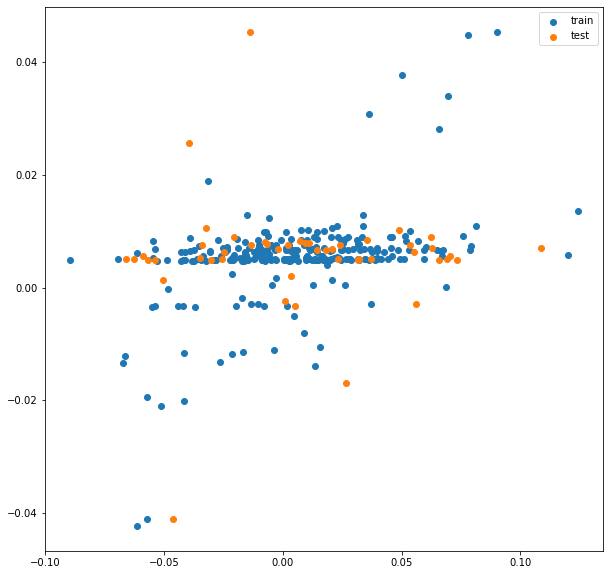

In [26]:
rfr = RandomForestRegressor(n_estimators=200, max_depth = 3, max_features = 2, random_state = 42)
rfr.fit(train_features, train_targets)

train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)


fig=plt.figure(figsize=(10,10))
plt.scatter(train_targets, train_predictions, label = 'train')
plt.scatter(test_targets, test_predictions, label = 'test')
plt.legend()
plt.show()

0.13313466368256788


-0.021134370677292402


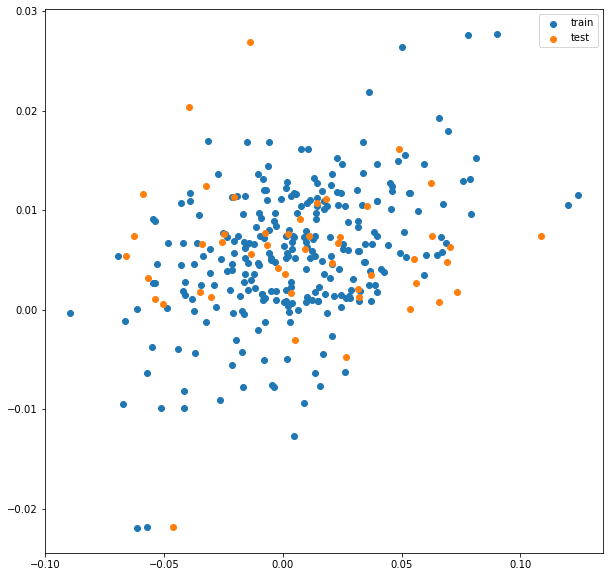

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_features=2, learning_rate = 0.01, n_estimators=200, subsample=0.1, random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print()
print()
print(gbr.score(test_features, test_targets))

train_predictions = gbr.predict(train_features)
test_predictions = gbr.predict(test_features)


fig=plt.figure(figsize=(10,10))
plt.scatter(train_targets, train_predictions, label = 'train')
plt.scatter(test_targets, test_predictions, label = 'test')
plt.legend()
plt.show()

In [28]:
from sklearn.preprocessing import scale



scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

scaled_train_features, scaled_test_features

(array([[ 0.00000000e+00,  1.33132217e+00],
        [ 0.00000000e+00,  3.77769948e-01],
        [ 0.00000000e+00, -2.13001959e+00],
        [ 0.00000000e+00, -1.01048679e+00],
        [ 0.00000000e+00, -1.18711602e+00],
        [ 0.00000000e+00, -1.34732681e+00],
        [ 0.00000000e+00, -1.12217048e+00],
        [ 0.00000000e+00, -3.74015405e-01],
        [ 0.00000000e+00, -3.65933745e-01],
        [ 0.00000000e+00, -1.56585452e+00],
        [ 0.00000000e+00, -2.47355014e-01],
        [ 0.00000000e+00, -1.71903995e+00],
        [ 0.00000000e+00, -1.74448310e+00],
        [ 0.00000000e+00, -1.69283932e+00],
        [ 0.00000000e+00,  8.54459445e-01],
        [ 0.00000000e+00,  8.08793052e-01],
        [ 0.00000000e+00,  2.51952894e+00],
        [ 0.00000000e+00,  1.90481702e+00],
        [ 0.00000000e+00,  1.33562989e+00],
        [ 0.00000000e+00,  1.02434403e+00],
        [ 0.00000000e+00, -9.35183960e-02],
        [ 0.00000000e+00,  3.31370530e-03],
        [ 0.00000000e+00,  8.689

In [29]:
from sklearn.neighbors import KNeighborsRegressor


for n in range(2, 20):
    knn = KNeighborsRegressor(n_neighbors= n)
    knn.fit(scaled_train_features, train_targets)
    
    print('n_neighbors = ', n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()
    
#would assume that 15 is the ideal trade-off of computation and good knn score on unseen data

n_neighbors =  2
train, test scores
0.49800125683460694
-0.10507627795971208

n_neighbors =  3
train, test scores
0.3367076429513328
-0.19811194656295394

n_neighbors =  4
train, test scores
0.26032929069465616
-0.143061444926601

n_neighbors =  5
train, test scores
0.1987920476538848
-0.13740857651386507

n_neighbors =  6
train, test scores
0.16842742131918742
-0.11020236453527343

n_neighbors =  7
train, test scores
0.14599512443778295
-0.03313377820159724

n_neighbors =  8
train, test scores
0.15353847780837815
-0.02162719131631574

n_neighbors =  9
train, test scores
0.11038602546253384
-0.0009183479077472523

n_neighbors =  10
train, test scores
0.12257121746672273
0.003936727051804145

n_neighbors =  11
train, test scores
0.10151356941151435
-0.0009909085532722184

n_neighbors =  12
train, test scores
0.09471356008593201
0.007161609651807566

n_neighbors =  13
train, test scores
0.08322487266502743
0.011808132618855383

n_neighbors =  14
train, test scores
0.09208716969526787
0.0

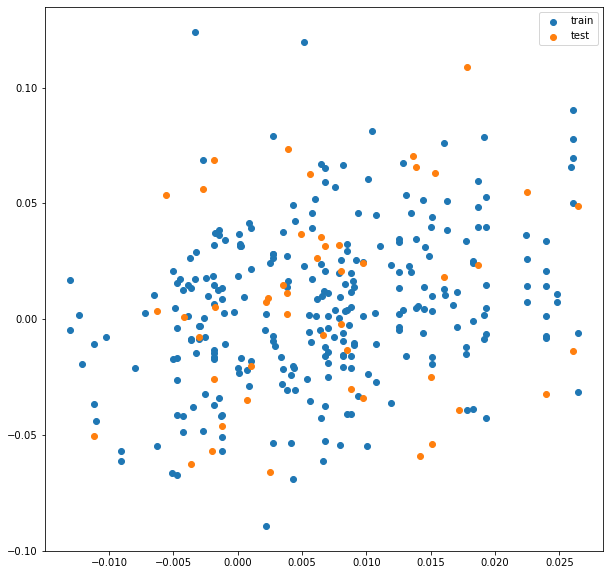

In [30]:
knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(scaled_train_features, train_targets)

train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

fig=plt.figure(figsize=(10,10))
plt.scatter(train_predictions, train_targets, label = 'train')
plt.scatter(test_predictions, test_targets, label = 'test')
plt.legend()
plt.show()

In [34]:
from keras.models import Sequential
from keras.layers import Dense

model_1 = Sequential()
model_1.add(Dense(100, input_dim = scaled_train_features.shape[1], activation = 'relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(optimizer ='adam', loss = 'mse')
history = model_1.fit(scaled_train_features, train_targets, epochs = 25)
history

ModuleNotFoundError: No module named 'tensorflow'